# Week 1 - Linear Programming

## Intro to LP

In [1]:
import numpy as np
import pandas as pd
from pulp import *

## 1) Product Mix Example

Result from using Excel Solver.

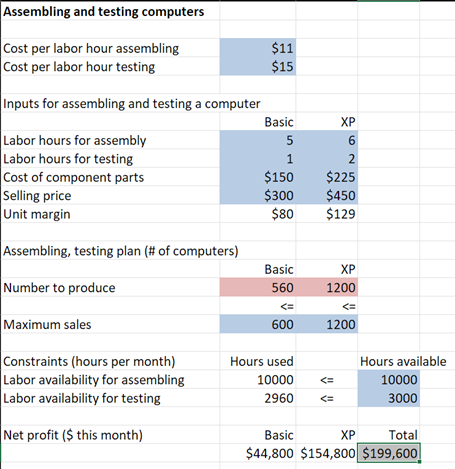

### Problem formulation

Note that not using "Integer" is intentional. As this is still an introduction to Linear Programming.

In [3]:
sku_names = ['Basic','XP']
n_sku = len(sku_names)

margins = np.array([80, 129])


prob = LpProblem('ProductMix', LpMaximize)
decision_vars = LpVariable.matrix('X', sku_names, lowBound=0)

# Objective function
obj_func = lpSum(decision_vars * margins)
prob += obj_func

# Maximum sales constraints
sales_limits = np.array([600, 1200])
for i in range(n_sku):
    prob += (decision_vars[i] <= sales_limits[i]), f"Maximum sales constraints {i+1}"
    
# Labor hour constraints
labor_hours = np.array([
    [5, 6],
    [1, 2]
])
labor_limits = np.array([10000, 3000])

for j,labor_limit in enumerate(labor_limits):
    prob += lpSum(decision_vars * labor_hours[j]) <= labor_limit, f"Labor constraints {j+1}"

prob

ProductMix:
MAXIMIZE
80*X_Basic + 129*X_XP + 0
SUBJECT TO
Maximum_sales_constraints_1: X_Basic <= 600

Maximum_sales_constraints_2: X_XP <= 1200

Labor_constraints_1: 5 X_Basic + 6 X_XP <= 10000

Labor_constraints_2: X_Basic + 2 X_XP <= 3000

VARIABLES
X_Basic Continuous
X_XP Continuous

### Solve

In [4]:
prob.solve()
print(f"Status: {LpStatus[prob.status]}")
print(f"Objective value: {prob.objective.value()}")
for v in prob.variables():
    print(f"{v.name} = {v.value()}")

Status: Optimal
Objective value: 199600.0
X_Basic = 560.0
X_XP = 1200.0


## 2) Product Mix + one more SKU

Still, intentionally leave the decision variables as "Continuous".

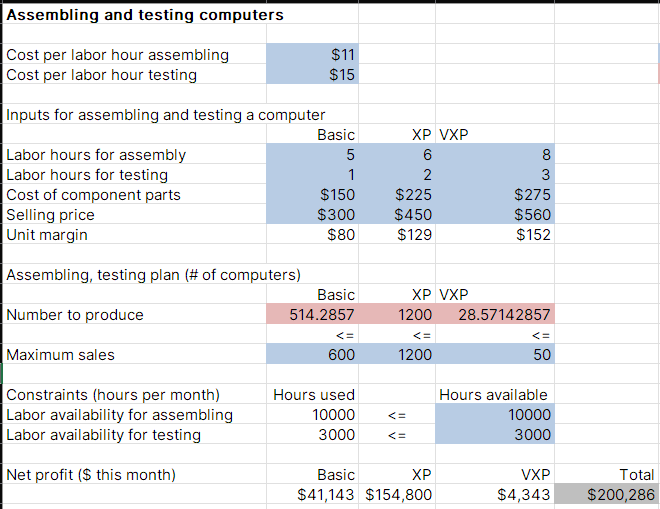

### Problem formulation

In [5]:
sku_names = ['Basic','XP','VXP']
n_sku = len(sku_names)

margins = np.array([80, 129, 152])


prob = LpProblem('ProductMix', LpMaximize)
decision_vars = LpVariable.matrix('X', sku_names, lowBound=0)

# Objective function
obj_func = lpSum(decision_vars * margins)
prob += obj_func

# Maximum sales constraints
sales_limits = np.array([600, 1200, 50])
for i in range(n_sku):
    prob += (decision_vars[i] <= sales_limits[i]), f"Maximum sales constraints {i+1}"
    
# Labor hour constraints
labor_hours = np.array([
    [5, 6, 8],
    [1, 2, 3]
])
labor_limits = np.array([10000, 3000])

for j,labor_limit in enumerate(labor_limits):
    prob += lpSum(decision_vars * labor_hours[j]) <= labor_limit, f"Labor constraints {j+1}"

prob

ProductMix:
MAXIMIZE
80*X_Basic + 152*X_VXP + 129*X_XP + 0
SUBJECT TO
Maximum_sales_constraints_1: X_Basic <= 600

Maximum_sales_constraints_2: X_XP <= 1200

Maximum_sales_constraints_3: X_VXP <= 50

Labor_constraints_1: 5 X_Basic + 8 X_VXP + 6 X_XP <= 10000

Labor_constraints_2: X_Basic + 3 X_VXP + 2 X_XP <= 3000

VARIABLES
X_Basic Continuous
X_VXP Continuous
X_XP Continuous

### Solve

In [6]:
prob.solve()
print(f"Status: {LpStatus[prob.status]}")
print(f"Objective value: {prob.objective.value()}")
for v in prob.variables():
    print(f"{v.name} = {v.value()}")

Status: Optimal
Objective value: 200285.7328
X_Basic = 514.286
X_VXP = 28.5714
X_XP = 1200.0


## 3) Assignment 1

The assignment was previously done in Excel. Using PuLP to get the same result.

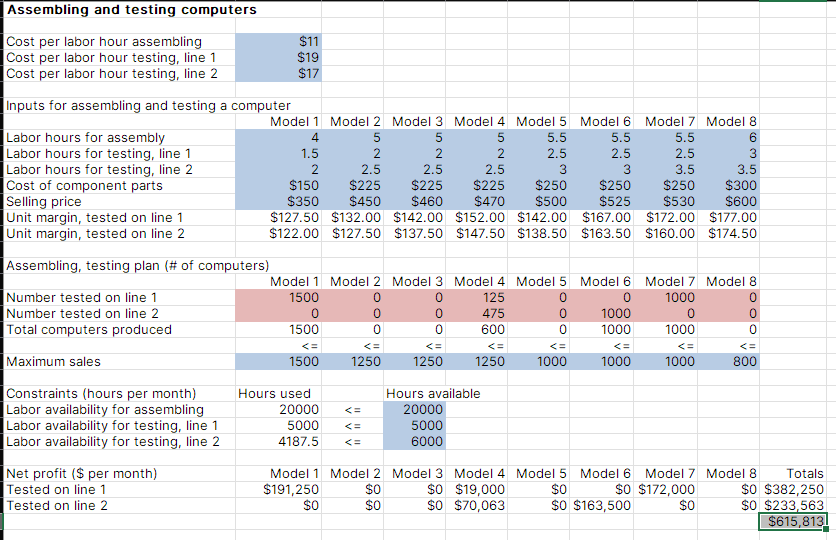

### Setting up product master

In [74]:
sku_names = [ f"Model{i}" for i in range(1, 9) ]
asm_hr = [4, 5, 5, 5, 5.5, 5.5, 5.5, 6]
test_hr_1 = [1.5, 2, 2, 2, 2.5, 2.5, 2.5, 3]
test_hr_2 = [2, 2.5, 2.5, 2.5, 3, 3, 3.5, 3.5]
cost_part = [150, 225, 225, 225, 250, 250, 250, 300]
sell_price = [350, 450, 460, 470, 500, 525, 530, 600]
max_sales_limit = [1500, 1250, 1250, 1250, 1000, 1000, 1000, 800]

cost_asm_per_hr = 11
cost_test_per_hr_1 = 19
cost_test_per_hr_2 = 17

df = pd.DataFrame({'asm_hr': asm_hr, 'test_hr_1': test_hr_1, 'test_hr_2': test_hr_2,
                   'cost_part': cost_part, 'sell_price': sell_price, 'max_sales_limit': max_sales_limit },
                 index=sku_names)
df['margin_test_1'] = df.sell_price - df.cost_part - cost_asm_per_hr * df.asm_hr - cost_test_per_hr_1 * df.test_hr_1
df['margin_test_2'] = df.sell_price - df.cost_part - cost_asm_per_hr * df.asm_hr - cost_test_per_hr_2 * df.test_hr_2
df

,asm_hr,test_hr_1,test_hr_2,cost_part,sell_price,max_sales_limit,margin_test_1,margin_test_2
Model1,4.0,1.5,2.0,150,350,1500,127.5,122.0
Model2,5.0,2.0,2.5,225,450,1250,132.0,127.5
Model3,5.0,2.0,2.5,225,460,1250,142.0,137.5
Model4,5.0,2.0,2.5,225,470,1250,152.0,147.5
Model5,5.5,2.5,3.0,250,500,1000,142.0,138.5
Model6,5.5,2.5,3.0,250,525,1000,167.0,163.5
Model7,5.5,2.5,3.5,250,530,1000,172.0,160.0
Model8,6.0,3.0,3.5,300,600,800,177.0,174.5


### Prepare decision variables

In [83]:
margin_matrix = df[['margin_test_1', 'margin_test_2']].values
margin_matrix

array([[127.5, 122. ],
       [132. , 127.5],
       [142. , 137.5],
       [152. , 147.5],
       [142. , 138.5],
       [167. , 163.5],
       [172. , 160. ],
       [177. , 174.5]])

In [110]:
# i : model i
# j : test line j
n_skus = len(sku_names)
n_lines = 2

# Decision variables

var_names = [f"{i}{j}" for i in range(1, n_skus+1) for j in range(1, n_lines+1)]
decision_vars = LpVariable.matrix('X', var_names, lowBound=0)
allocation = np.array(decision_vars).reshape(n_skus, n_lines)
print(f"Decision Variables:\n{allocation}")

Decision Variables:
[[X_11 X_12]
 [X_21 X_22]
 [X_31 X_32]
 [X_41 X_42]
 [X_51 X_52]
 [X_61 X_62]
 [X_71 X_72]
 [X_81 X_82]]


### Create problem and objective function

In [111]:
# Objective function
prob = LpProblem('ProductMix', LpMaximize)
obj_func = lpSum(allocation * margin_matrix)
prob += obj_func
print(obj_func)

127.5*X_11 + 122.0*X_12 + 132.0*X_21 + 127.5*X_22 + 142.0*X_31 + 137.5*X_32 + 152.0*X_41 + 147.5*X_42 + 142.0*X_51 + 138.5*X_52 + 167.0*X_61 + 163.5*X_62 + 172.0*X_71 + 160.0*X_72 + 177.0*X_81 + 174.5*X_82


### Constraints

In [112]:
# Maximum sales constraints
sales_limits = df.max_sales_limit.values
for i, sales_limit in enumerate(sales_limits):
    print(lpSum(allocation[i,:]) <= sales_limit)
    prob += lpSum(allocation[i,:]) <= sales_limit, f"Max_sales_{i+1}"

X_11 + X_12 <= 1500
X_21 + X_22 <= 1250
X_31 + X_32 <= 1250
X_41 + X_42 <= 1250
X_51 + X_52 <= 1000
X_61 + X_62 <= 1000
X_71 + X_72 <= 1000
X_81 + X_82 <= 800


In [113]:
# Assembling labor constraint
labor_asm_limit = 20000

labor_asm_constraint = lpSum((allocation[:,0] + allocation[:,1])*df.asm_hr) <= labor_asm_limit
print('Assembling_labor:', labor_asm_constraint, sep='\n')
prob += labor_asm_constraint, 'Assembling_labor'

# Testing labor constraints

labor_test_limit_1 = 5000
labor_test_limit_2 = 6000

labor_test_1_constraint = lpSum(allocation[:,0] * df.test_hr_1) <= labor_test_limit_1
print('Testing_labor_1:', labor_test_1_constraint, sep='\n')
prob += labor_test_1_constraint, 'Testing_labor_1'

labor_test_2_constraint = lpSum(allocation[:,1] * df.test_hr_2) <= labor_test_limit_2
print('Testing_labor_2:', labor_test_2_constraint, sep='\n')
prob += labor_test_2_constraint, 'Testing_labor_2'

Assembling_labor:
4.0*X_11 + 4.0*X_12 + 5.0*X_21 + 5.0*X_22 + 5.0*X_31 + 5.0*X_32 + 5.0*X_41 + 5.0*X_42 + 5.5*X_51 + 5.5*X_52 + 5.5*X_61 + 5.5*X_62 + 5.5*X_71 + 5.5*X_72 + 6.0*X_81 + 6.0*X_82 <= 20000.0
Testing_labor_1:
1.5*X_11 + 2.0*X_21 + 2.0*X_31 + 2.0*X_41 + 2.5*X_51 + 2.5*X_61 + 2.5*X_71 + 3.0*X_81 <= 5000.0
Testing_labor_2:
2.0*X_12 + 2.5*X_22 + 2.5*X_32 + 2.5*X_42 + 3.0*X_52 + 3.0*X_62 + 3.5*X_72 + 3.5*X_82 <= 6000.0


### Solve the problem
Let's review it first.

In [114]:
prob

ProductMix:
MAXIMIZE
127.5*X_11 + 122.0*X_12 + 132.0*X_21 + 127.5*X_22 + 142.0*X_31 + 137.5*X_32 + 152.0*X_41 + 147.5*X_42 + 142.0*X_51 + 138.5*X_52 + 167.0*X_61 + 163.5*X_62 + 172.0*X_71 + 160.0*X_72 + 177.0*X_81 + 174.5*X_82 + 0.0
SUBJECT TO
Max_sales_1: X_11 + X_12 <= 1500

Max_sales_2: X_21 + X_22 <= 1250

Max_sales_3: X_31 + X_32 <= 1250

Max_sales_4: X_41 + X_42 <= 1250

Max_sales_5: X_51 + X_52 <= 1000

Max_sales_6: X_61 + X_62 <= 1000

Max_sales_7: X_71 + X_72 <= 1000

Max_sales_8: X_81 + X_82 <= 800

Assembling_labor: 4 X_11 + 4 X_12 + 5 X_21 + 5 X_22 + 5 X_31 + 5 X_32 + 5 X_41
 + 5 X_42 + 5.5 X_51 + 5.5 X_52 + 5.5 X_61 + 5.5 X_62 + 5.5 X_71 + 5.5 X_72
 + 6 X_81 + 6 X_82 <= 20000

Testing_labor_1: 1.5 X_11 + 2 X_21 + 2 X_31 + 2 X_41 + 2.5 X_51 + 2.5 X_61
 + 2.5 X_71 + 3 X_81 <= 5000

Testing_labor_2: 2 X_12 + 2.5 X_22 + 2.5 X_32 + 2.5 X_42 + 3 X_52 + 3 X_62
 + 3.5 X_72 + 3.5 X_82 <= 6000

VARIABLES
X_11 Continuous
X_12 Continuous
X_21 Continuous
X_22 Continuous
X_31 Continuous

In [115]:
prob.solve()
print(f"Status: {LpStatus[prob.status]}")
print(f"Objective value: {prob.objective.value()}")
for v in prob.variables():
    print(f"{v.name} = {v.value()}")

Status: Optimal
Objective value: 615812.5
X_11 = 1500.0
X_12 = 0.0
X_21 = 0.0
X_22 = 0.0
X_31 = 0.0
X_32 = 0.0
X_41 = 125.0
X_42 = 475.0
X_51 = 0.0
X_52 = 0.0
X_61 = 0.0
X_62 = 1000.0
X_71 = 1000.0
X_72 = 0.0
X_81 = 0.0
X_82 = 0.0


### Display result

Using the same format as in the given question.

In [121]:
result_df = pd.DataFrame(np.array([ v.value() for v in prob.variables() ]).reshape(n_skus, n_lines), index=df.index, columns=['test_line_1','test_line_2'])
print('Maximized margin =', prob.objective.value())
result_df.T

Maximized margin = 615812.5


,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
test_line_1,1500.0,0.0,0.0,125.0,0.0,0.0,1000.0,0.0
test_line_2,0.0,0.0,0.0,475.0,0.0,1000.0,0.0,0.0
